In [1]:
import polars as pl
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [ ]:
df = pl.scan_parquet("../../data/edges")
df_w = pl.scan_parquet("../../data/wordcounts")
df_t = pl.scan_parquet("../../data/topics")
df_s = pl.scan_parquet("../../data/stances")
df = df.join(df_t.select("position", "topics"), on="position", how="left")
df = df.join(df_s.select("pos", "parsed_stance"), left_on="position",right_on="pos", how="left")
df = df.with_columns(pl.col("Date").str.to_date())
df = df.sort("Date", descending=False)
df = df.filter(pl.col("Party_orientation") != "-")

In [3]:
# Extract topic
df = df.filter(pl.col("topics").is_not_null())

def max_key_from_json(s):
    try:
        d = json.loads(s)
        return max(d, key=d.get)
    except Exception as e:
        return str(e)

df = df.with_columns([
    pl.col("topics")
    .str.replace_all("'", '"')   
    .map_elements(max_key_from_json, return_dtype=pl.String)
    .str.replace(r"[0-9]{3} \- ", "")
    .str.replace(r"\:.*", "")
    .alias("topics_e")
])

In [4]:
df = df.with_columns(
    pl.col("parsed_stance")
    .replace({"NEGATIVE": -1, "NEUTRAL": 0, "POSITIVE": 1,"": None})
    .cast(pl.Int16).alias("sentiment")
)

In [ ]:
df = df.filter(pl.col("entity") == "europe")
df = df.filter(pl.col("source_country") == "FR")

In [5]:
df_g = df.group_by_dynamic("Date", every="1y", group_by=["Party_orientation", "topics_e"]).len().sort("len").drop_nulls()
df_totals = df_g.group_by("Party_orientation", "Date").agg(pl.col("len").sum()).rename({"len":"sum"})
df_g = df_g.join(df_totals, on=["Party_orientation","Date"], how="left")
df_g = df_g.with_columns((pl.col("len") / pl.col("sum")).alias("proportion"))
df_g = df_g.filter(pl.col("Party_orientation") != "-")

In [6]:
def generate_wordcloud(df_wc, title):
#group by year as well as topic, calculate count and average sentiment
    df_wc = df_wc.group_by_dynamic("Date", every="1y", group_by=["topics_e"]).agg(
        pl.col("sentiment").mean().alias("avg_sentiment"),
        pl.len().alias("len")
    ).sort("len").drop_nulls()

#set year
    df_wc = df_wc.filter(pl.col("Date") == datetime.datetime(2020,1,1))

#create dict with word frequencies
    df_collected = df_wc.collect()
    keys = df_collected.get_column("topics_e").to_list()
    vals = df_collected.get_column("len").to_list()
    vals_sent = df_collected.get_column("avg_sentiment").to_list()

    freq_dict = dict(sorted(zip(keys, vals), key=lambda x: -x[1]))
    sent_dict = dict(zip(keys, vals_sent))

# custom color function
    def colorfs(word, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
        color = plt.get_cmap("coolwarm")((sent_dict[word] + 1) / 2)
        rgb = tuple(int(255 * c) for c in color[:3])
        return '#{:02x}{:02x}{:02x}'.format(*rgb)
#make word cloud
    w = WordCloud(width=1920, height=1080,background_color="white",collocations=False, color_func=colorfs)
    w.generate_from_frequencies(freq_dict)
    plt.imshow(w, interpolation='nearest', aspect='auto')
    plt.title(title,fontsize=10)
    plt.axis("off")
    plt.show()
    

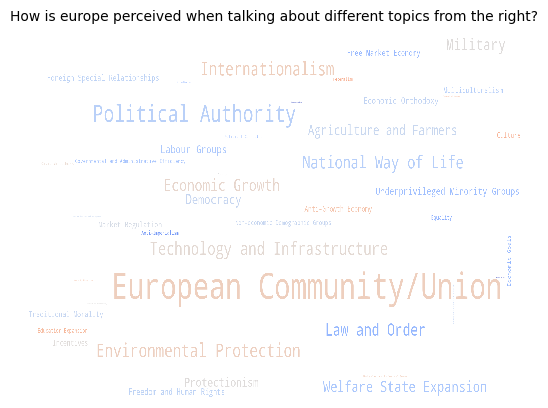

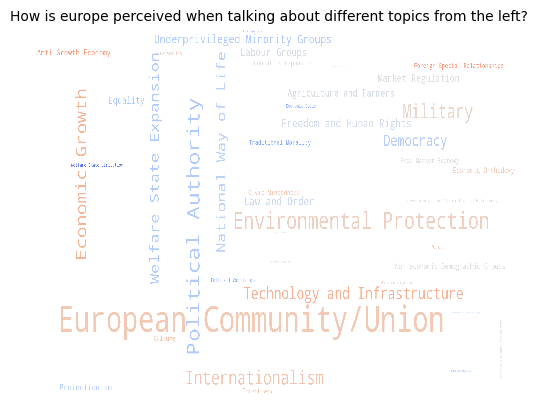

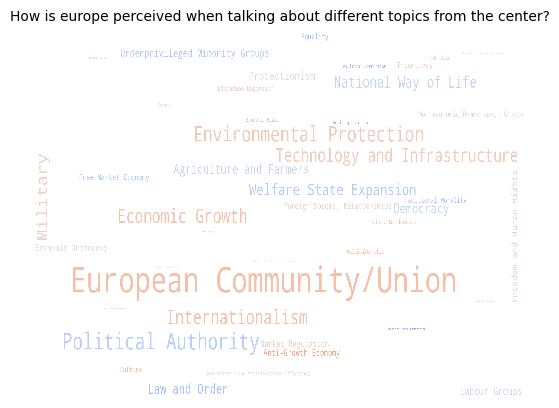

In [8]:
from wordcloud import WordCloud

#Filter party orientation
df_right = df.filter(pl.col("Party_orientation").str.contains("[Rr]ight"))
df_left = df.filter(pl.col("Party_orientation").str.contains("[Ll]eft"))
df_cent = df.filter(pl.col("Party_orientation").str.contains("[cC]entre"))

generate_wordcloud(df_right, "How is europe perceived when talking about different topics from the right?")
generate_wordcloud(df_left, "How is europe perceived when talking about different topics from the left?")
generate_wordcloud(df_cent, "How is europe perceived when talking about different topics from the center?")
